# Carvana Image Masking Challenge 

The goal of this challenge is to create a machine learning model capable of masking images. So that the car will be separated from the background.

[DATA](https://www.kaggle.com/c/carvana-image-masking-challenge/data)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

from torchvision import transforms, datasets
import torchvision.models as models

# Exploring Metadata
Considering how large this dataset is. It would be beneficial to know what types and years the cars that populate this dataset are.

In [3]:
df = pd.read_csv('data/metadata.csv')
df = df.dropna()
df.shape

(6485, 6)

# Number of Cars by Year

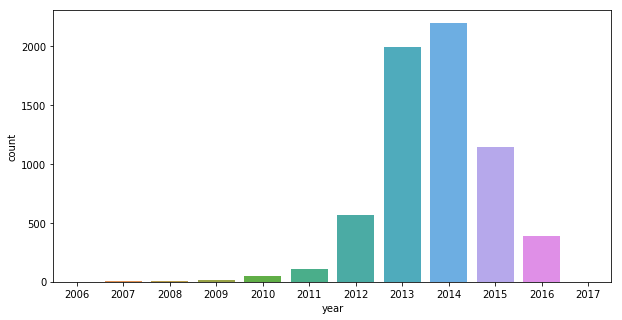

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df['year'].astype('int'))
plt.show()

# Number of Cars by Make

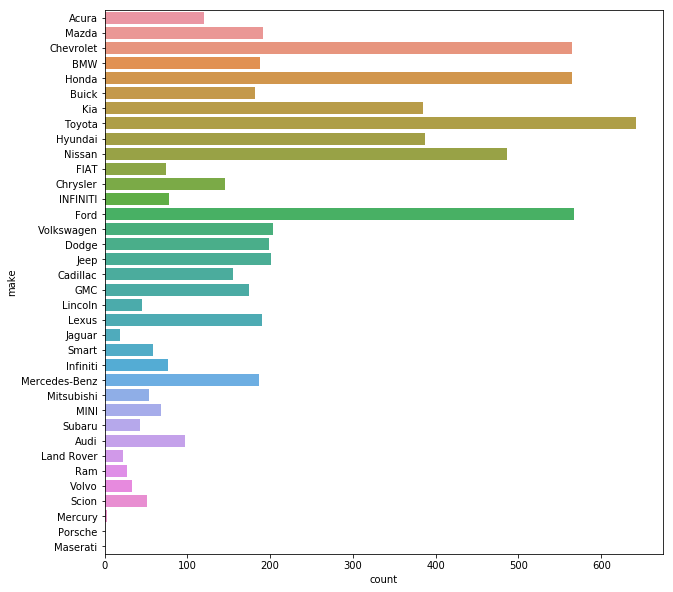

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y=df['make'], orient='h')
plt.show()

# Previewing Train Images

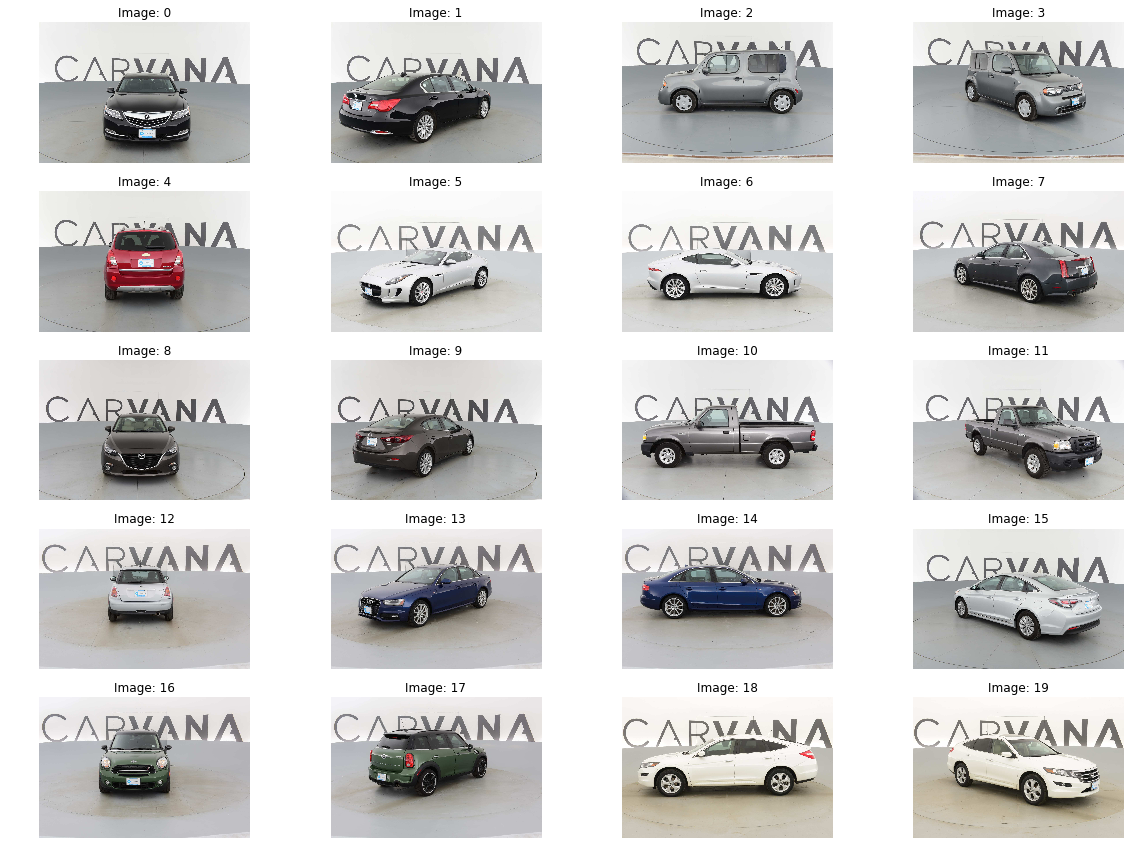

In [6]:
def get_images(folder, img_type, image_iter=None):
    fig = plt.figure(figsize=(20, 15))
    
    images = glob.glob(folder + '/*.' + img_type)
    
    if image_iter is not None:
        images = images[0::image_iter] # Selecting every 10th image to get a better variety

    counter = 0
    for image in images:
        if counter >= 20:
            break
        plt.subplot(5, 4, counter + 1)
        plt.axis('off')
        preview = Image.open(image)
        preview = np.array(preview)
        plt.imshow(preview.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(f'Image: {counter}')
        counter += 1

    plt.show()

folder = './data/train'
img_type = 'jpg'
image_iter = 10

get_images(folder, img_type, image_iter)

# Previewing Test Images

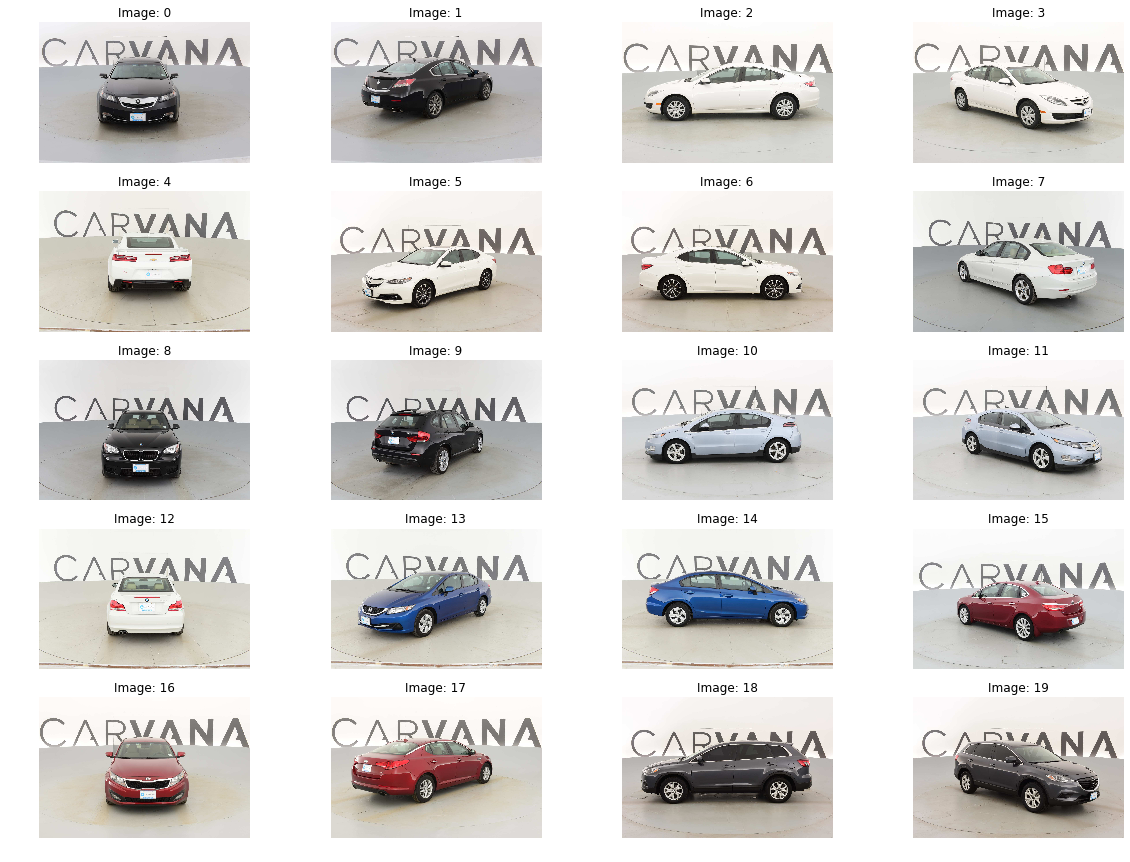

In [7]:
folder = './data/test'
img_type = 'jpg'
image_iter = 10

get_images(folder, img_type, image_iter)

# Previewing Masks 

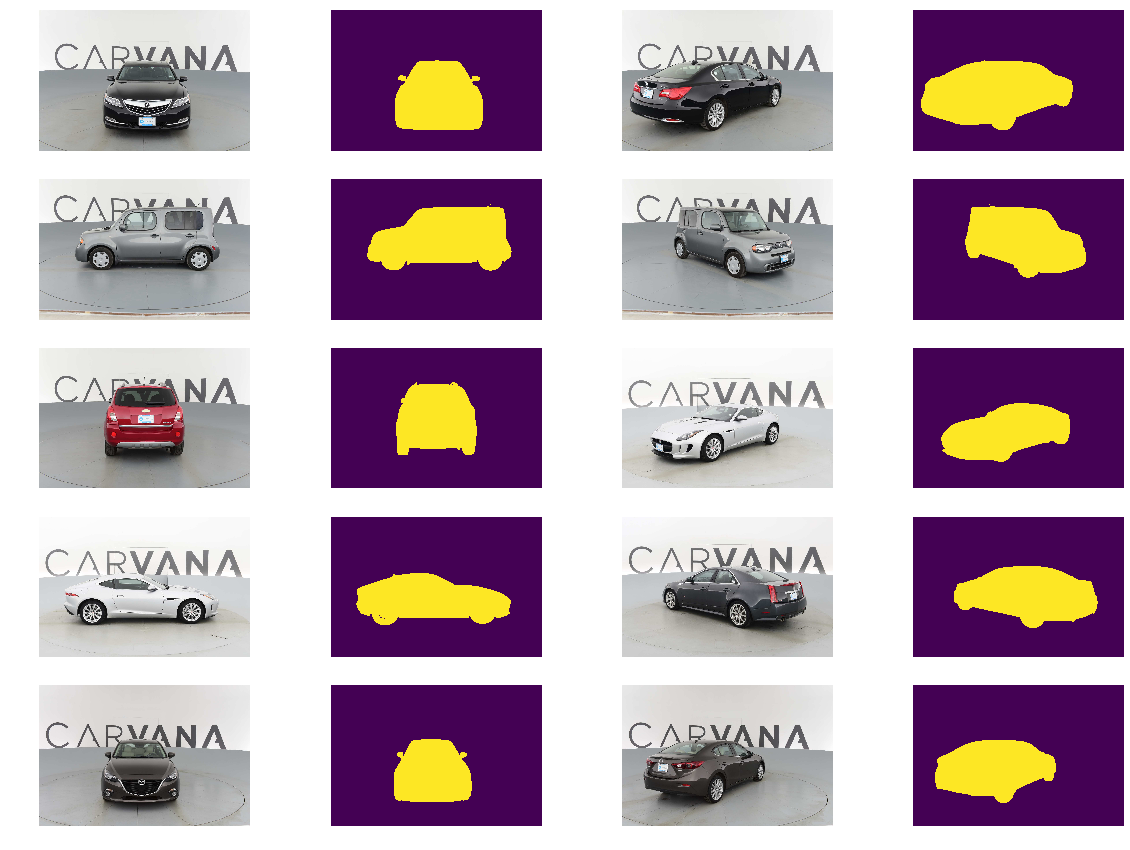

In [8]:
fig = plt.figure(figsize=(20, 15))

train = glob.glob('./data/train/*.jpg')
masks = glob.glob('./data/train_masks/*.gif' )
image_iter = 10

train = train[0::image_iter] # Selecting every 10th image to get a better variety
masks = masks[0::image_iter]

counter = 0
for image, mask in zip(train, masks):
    if counter >= 20:
        break
    plt.subplot(5, 4, counter + 1)
    plt.axis('off')
    train = Image.open(image)
    train = np.array(train)
    mask = Image.open(mask)
    mask = np.array(mask)
    plt.imshow(train.squeeze(), interpolation='nearest')
    counter +=1
    
    plt.subplot(5, 4, counter + 1)
    plt.axis('off')
    plt.imshow(mask.squeeze(), interpolation='nearest')
    counter += 1

plt.show()

# Data Loading

In [9]:
batch_size = 1

class CarvanaDataset(Dataset):
    def __init__(self, operation='train', transform=None):
        self.operation = operation
        self.transform = transform
        
        if self.operation == 'train':
            self.imgs = glob.glob('../final/data/train/*.jpg')
            self.labels = glob.glob('../final/data/train_masks/*.gif')
            
        elif self.operation == 'test':
            self.imgs = glob.glob('../final/data/test/*.jpg')
            self.labels = glob.glob('../final/data/train_masks/*.gif')
            
    def __getitem__(self, index):
        # Load images and labels
        img = Image.open(self.imgs[index]).convert('RGB')
        target = Image.open(self.labels[index]).convert('1')
        
        # Apply transformations
        if self.transform is not None:
            img = self.transform(img)
            img /= 255.0
            target = self.transform(target)
            
        return img, target
    
    def __len__(self):
        return len(self.imgs)
    
data_transform = transforms.Compose([
        transforms.Resize([256,256]),
        transforms.ToTensor()
    ])

train_dataset = CarvanaDataset(transform=data_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# PyTorch Fully Convolutional Neural Network.

This architecture has been proven to be a strong contender for image segmentation tasks. By not including a fully connected linear layer the convolutional layers can focus on features within the images. The downside to fully convolutional neural networks is that they're computationally expensive. However by downsampling, max pooling and then upsampling the overall computational cost can be reduced. The following neural net architecture below closely follows the research proposed in the U-Net paper. The main idea is to use the features learned form downsampling to help rescale the image. By doing so it helps assure a crisper mask.

For an imaging task like this that doesn't require speed but accuracy U-Net is the clear winner. Other approaches like YOLO(You Only Look Once) that makes use of a fast RCNN architecture is much faster but typically produces less accurate masks. 

![U-Net](https://cdn-images-1.medium.com/max/1600/1*lvXoKMHoPJMKpKK7keZMEA.png)


In [10]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode, align):
        super(Interpolate, self).__init__()
        self.interp = F.interpolate
        self.scale = scale_factor
        self.mode = mode
        self.align = align
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale, mode=self.mode, align_corners=self.align)
        return x

class ConvNet(nn.Module):
    def __init__(self, use_vgg=False):
        super(ConvNet, self).__init__()
        
        if use_vgg:
            self.encoder = models.vgg11(pretrained=True).features
            self.relu = self.encoder[1]
            self.maxpool = self.encoder[2]
            self.down_layer1 = nn.Sequential(
                self.encoder[0],
                self.relu,
                self.encoder[3],
                self.relu
            )
            
            self.down_layer2 = nn.Sequential(
                self.encoder[6],
                self.relu,
                self.encoder[8],
                self.relu
            )
            
            self.down_layer3 = nn.Sequential(
                self.encoder[11],
                self.relu,
                self.encoder[13],
                self.relu
            )
            
            self.down_layer4 = nn.Sequential(
                self.encoder[16],
                self.relu,
                self.encoder[18],
                self.relu
            )

            self.center = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True))

            self.maxpool = nn.MaxPool2d(2)
            
        
        self.up_sample_layer = nn.Sequential(
             Interpolate(scale_factor=2, mode='bilinear', align=True),
        )    
        
        if use_vgg:
            self.up_layer1 = nn.Sequential(
                 nn.Conv2d(512, 512, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(512, 512, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))

            self.up_layer2 = nn.Sequential(
                 nn.Conv2d(1024, 256, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(256, 256, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))

            self.up_layer3 = nn.Sequential(
                 nn.Conv2d(768, 128, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(128, 128, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))
            
            self.up_layer4 = nn.Sequential(
                 nn.Conv2d(384, 64, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(64, 64, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))
            
            self.up_layer5 = nn.Sequential(
                 nn.Conv2d(192, 64, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(64, 64, kernel_size=3, padding=1),
                 nn.ReLU(inplace=True))
        
            
        self.out_layer = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        
    def forward(self, x):
        conv1 = self.down_layer1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.down_layer2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down_layer3(x)
        x = self.maxpool(conv3)
        
        conv4 = self.down_layer4(x)
        x = self.maxpool(conv4)
        
        center = self.center(x)
        
        x = self.up_layer1(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv4], dim=1)
        
        x = self.up_layer2(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv3], dim=1)
        
        x = self.up_layer3(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.up_layer4(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.up_layer5(x)
        
        x = self.out_layer(x)
        
        return x
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_layer1 = nn.Sequential(
             nn.Conv2d(3, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(64, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))
        
        self.down_layer2 = nn.Sequential(
             nn.Conv2d(64, 128, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(128, 128, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))
        
        self.down_layer3 = nn.Sequential(
             nn.Conv2d(128, 256, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(256, 256, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))
        
        self.down_layer4 = nn.Sequential(
             nn.Conv2d(256, 512, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))
        
        self.center = nn.Sequential(
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))

        self.maxpool = nn.MaxPool2d(2)


        self.up_sample_layer = nn.Sequential(
             Interpolate(scale_factor=2, mode='bilinear', align=True),
        )    
        
        self.up_layer1 = nn.Sequential(
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(512, 512, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))

        self.up_layer2 = nn.Sequential(
             nn.Conv2d(1024, 256, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(256, 256, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))

        self.up_layer3 = nn.Sequential(
             nn.Conv2d(512, 128, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(128, 128, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))

        self.up_layer4 = nn.Sequential(
             nn.Conv2d(256, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(64, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))

        self.up_layer5 = nn.Sequential(
             nn.Conv2d(128, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True),
             nn.Conv2d(64, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True))

            
        self.out_layer = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        
    def forward(self, x):
        conv1 = self.down_layer1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.down_layer2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down_layer3(x)
        x = self.maxpool(conv3)
        
        conv4 = self.down_layer4(x)
        x = self.maxpool(conv4)
        
        center = self.center(x)
        
        x = self.up_layer1(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv4], dim=1)
        
        x = self.up_layer2(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv3], dim=1)
        
        x = self.up_layer3(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.up_layer4(x)
        x = self.up_sample_layer(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.up_layer5(x)
        
        x = self.out_layer(x)
        
        return x

# Utilities
The following functions are needed to aid the convolutional neural network.

- The Dice loss is not included in PyTorch, below is the code to implementing it.

- Save model is a helper function to keep variations of the model.

In [11]:
def dice_loss(preds, trues, weight=None, is_average=True):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = 2. * (intersection + 1) / (preds.sum(1) + trues.sum(1) + 1)

    if is_average:
        score = scores.sum()/num
        return torch.clamp(score, 0., 1.)
    else:
        return scores

def dice_clamp(preds, trues, is_average=True):
    preds = torch.round(preds)
    return dice_loss(preds, trues, is_average=is_average)

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, input, target, weight=None):
        return 1-dice_loss(torch.sigmoid(input), target, weight=weight, is_average=self.reduction)

class BCEDiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        self.dice = DiceLoss(reduction=reduction)

    def forward(self, input, target, weight=None):
        return nn.modules.loss.BCEWithLogitsLoss(reduction=self.reduction, weight=weight)(input, target) + self.dice(input, target, weight=weight)

        
def save_model(model, epoch):
    out_dir = './data/models/UNET_' + str(epoch)
    torch.save(model.state_dict(), out_dir)

# U-Net PyTorch Model Using Transfer Learning
By using a model with pre-trained weights the training process will be accelerated. Hopefully implementing VGG11 will also increase the accuracy of the final result. I had two factors in selecting VGG11: first was computational limitations, and the second was that it scored very well amongst the smaller models.

In [19]:
model = ConvNet(use_vgg=True)
checkpoint = torch.load('G:\\projects\\thinkful\\final\\data\\models\\dice_test_epoch_round_2_19')
model.load_state_dict(checkpoint)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # After 10 epochs the learning rate will be reduced
criterion = BCEDiceLoss().cuda()

if torch.cuda.is_available():
    model = model.cuda()
    
models.vgg11(pretrained=True).features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17)

In [12]:
def train(train_loader, model, epoch, num_epochs):
    model.train()
    scheduler.step()

    # create a progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        hist = {}
        # Convert torch tensor to Variable
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # compute output
        optimizer.zero_grad()
        outputs = model(images)

        # measure loss
        loss = criterion(outputs, labels)
        hist['loss'] = loss.data

        # compute gradient and do optimizer step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)     # Prevents the gradient from going out of control
        optimizer.step()

        pbar.set_description('[TRAIN] - EPOCH %d/ %d - BATCH LOSS: %.4f'
                             % (epoch + 1, num_epochs, hist['loss']))
        
    return hist

### Running Model

In [14]:
n_epochs = 20

for epoch in range(n_epochs):
    curr_loss = train(train_loader, model, epoch, n_epochs)
    save_model(model, epoch)

print(f'Ending Loss - {curr_loss}')

[TRAIN] - EPOCH 20/ 20 - BATCH LOSS: 0.0045: 100%|█████████████████████████████████| 5088/5088 [18:14<00:00,  4.63it/s]


Ending Loss - {'loss': tensor(0.0045, device='cuda:0')}


# Previewing Results - Train Data
The model tested below has been ran for 40 epochs using the Adam optimizer. Epochs 0-10 were ran at a learning rate of 1e-3, 10-30 at 1e-4 and 30-40 at 1e-5. 

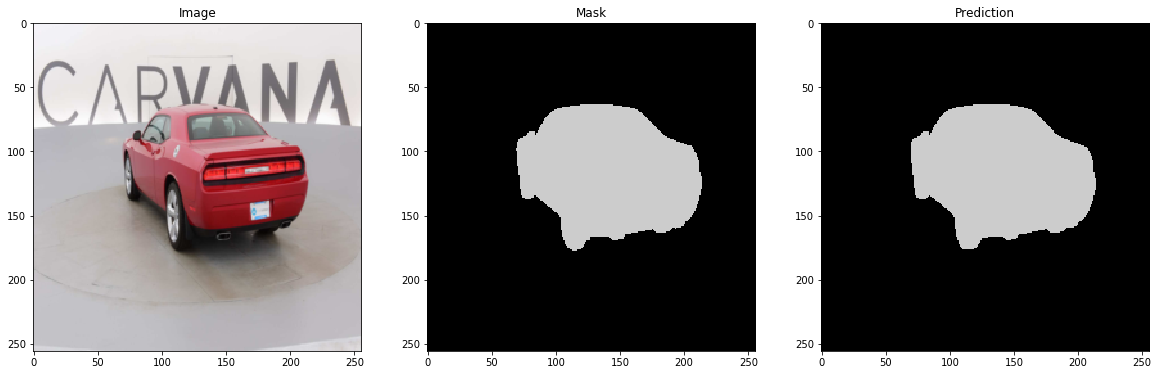

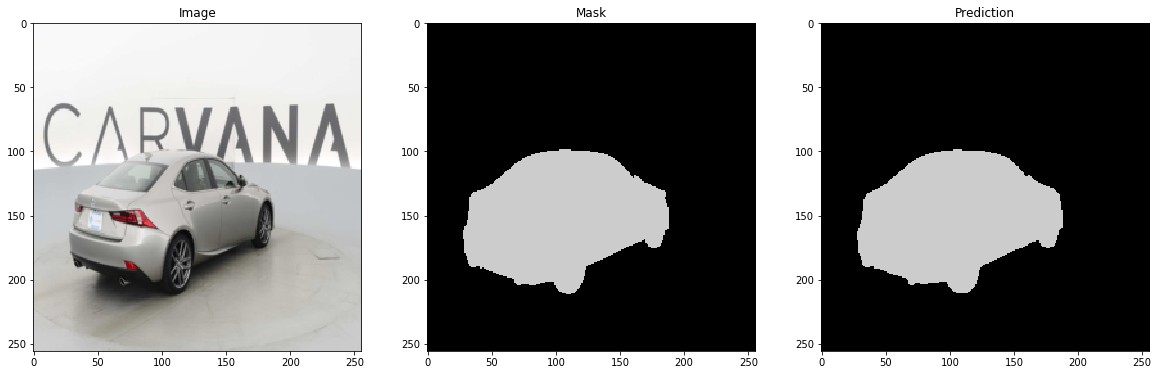

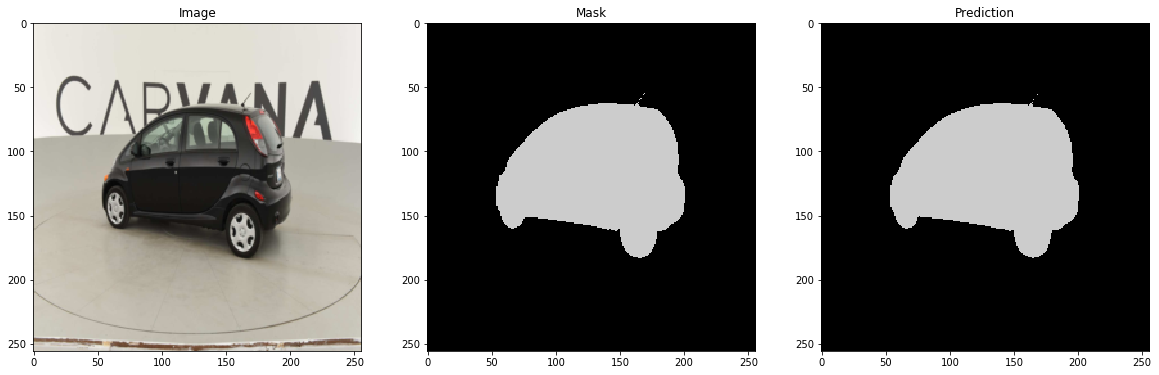

In [20]:
def model_preview():
    model.eval()
    counter = 0

    for i, (inputs, labels) in enumerate(train_loader):
        fig, axes = plt.subplots(1, 3, figsize=(20,15))
        row = counter
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Predict
        pred = model(inputs)
        pred = pred.data.cpu().numpy()
        pred = pred.squeeze()

        true = torch.sigmoid(labels)
        true = true.data.cpu().numpy()
        true = true.squeeze()

        img_p = inputs.data.cpu().numpy()
        img_p = img_p.squeeze()*255
        img_p = np.moveaxis(img_p, 0, -1)

        axes[0].imshow(img_p, interpolation='nearest')
        axes[1].imshow(true, cmap='nipy_spectral', interpolation='nearest')
        axes[2].imshow(pred > 0.5, cmap='nipy_spectral', interpolation='nearest')

        axes[0].set_title('Image')
        axes[1].set_title('Mask')
        axes[2].set_title('Prediction')
        counter += 1
        if counter > 2:
            break
        plt.show()

model_preview()

# Previewing Results - Test Data

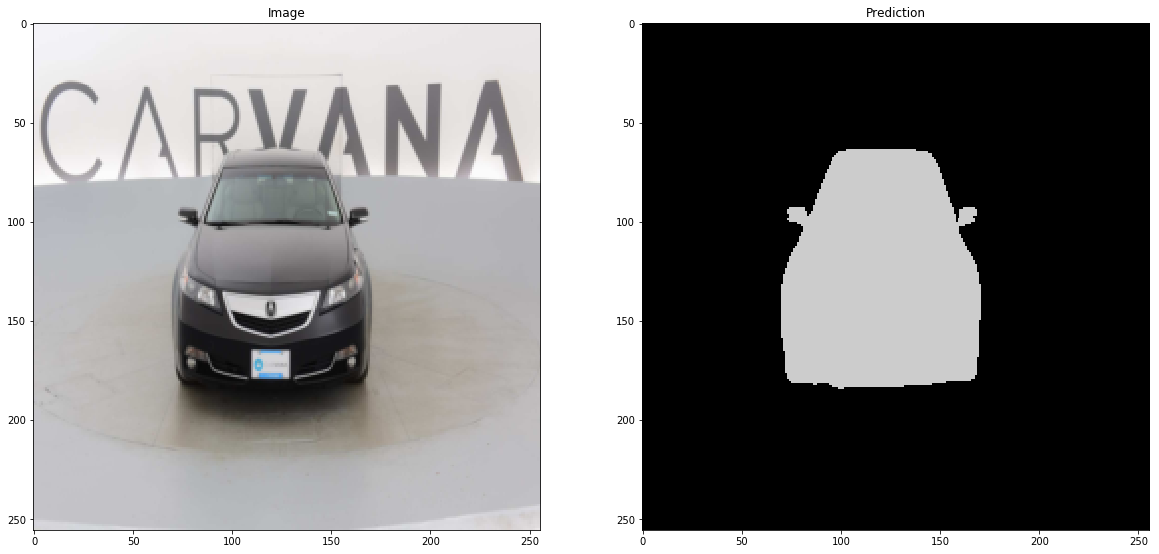

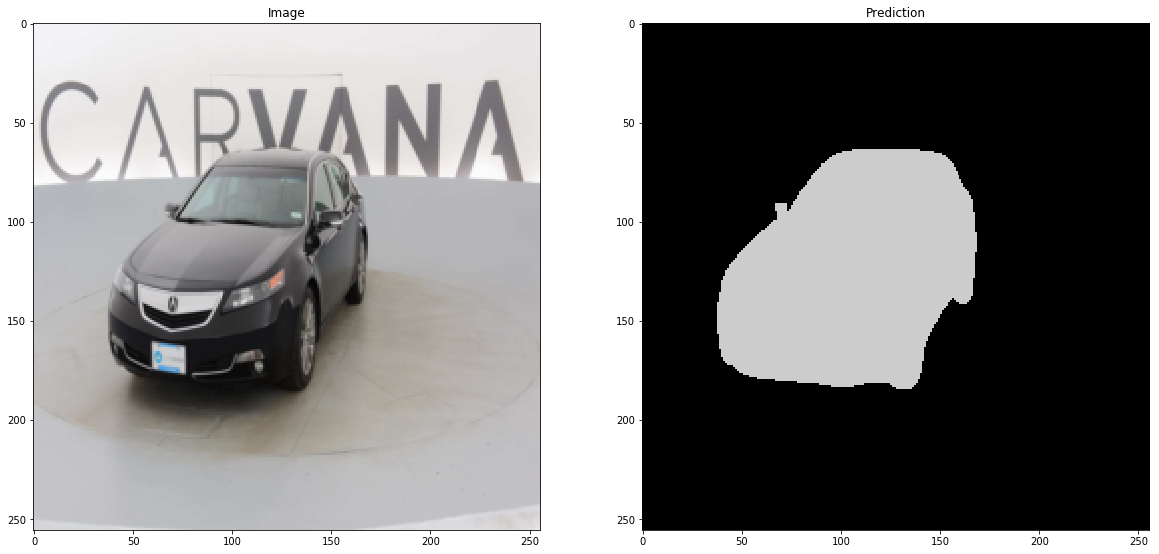

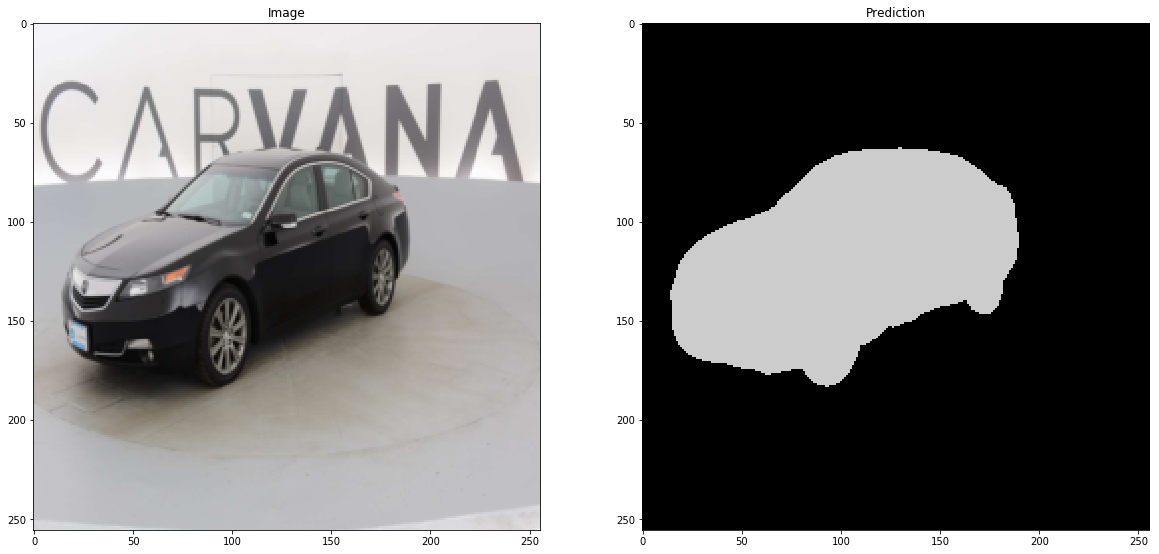

In [15]:
def test_data_preview():
    counter = 0
    model.eval()
    test_dataset = CarvanaDataset(operation='test', transform=data_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    for i, (inputs, labels) in enumerate(iter(test_loader)):
        fig, axes = plt.subplots(1, 2, figsize=(20,15))
        row = counter
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Predict
        pred = model(inputs)
        pred = pred.data.cpu().numpy()
        pred = pred.squeeze()

        img_p = inputs.data.cpu().numpy()
        img_p = img_p.squeeze()*255
        img_p = np.moveaxis(img_p, 0, -1)

        axes[0].imshow(img_p, interpolation='nearest')
        axes[1].imshow(pred > 0.5, cmap='nipy_spectral', interpolation='nearest')

        axes[0].set_title('Image')
        axes[1].set_title('Prediction')
        counter += 1
        if counter > 2:
            break
        plt.show()
        
test_data_preview()

# U-Net Fully Convolutional Neural Network
Training a model from scratch.

In [21]:
model = UNet()

load_fcn = True

if load_fcn:
    checkpoint = torch.load('G:\\projects\\thinkful\\final\\data\\models\\UNET_20')
    model.load_state_dict(checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # After 10 epochs the learning rate will be reduced
criterion = BCEDiceLoss().cuda()

n_epochs = 30

for epoch in range(n_epochs):
    curr_loss = train(train_loader, model, epoch, n_epochs)
    save_model(model, epoch)

print(f'Ending Loss - {curr_loss}')

[TRAIN] - EPOCH 23/ 30 - BATCH LOSS: 0.0138:  81%|██████████████████████████▋      | 4109/5088 [11:56<02:45,  5.91it/s]

# Previewing Images
After running the model for 23 epochs it appeared that the 21st epoch performed the best.

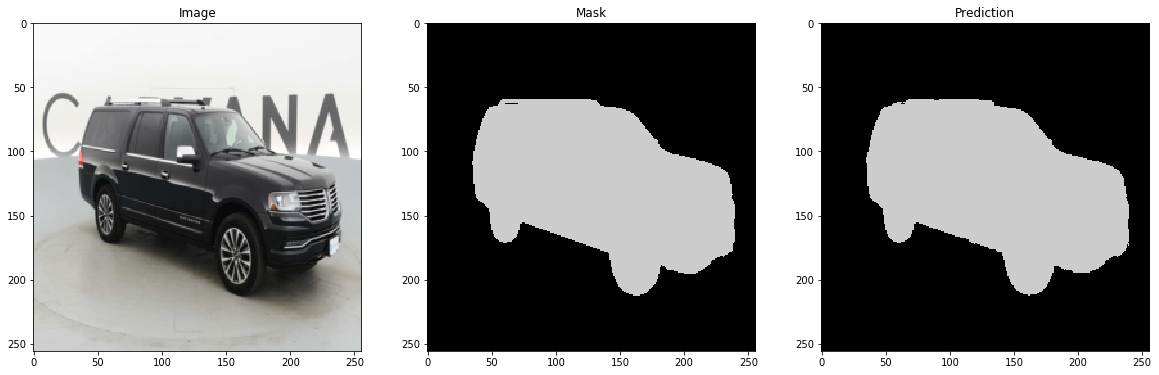

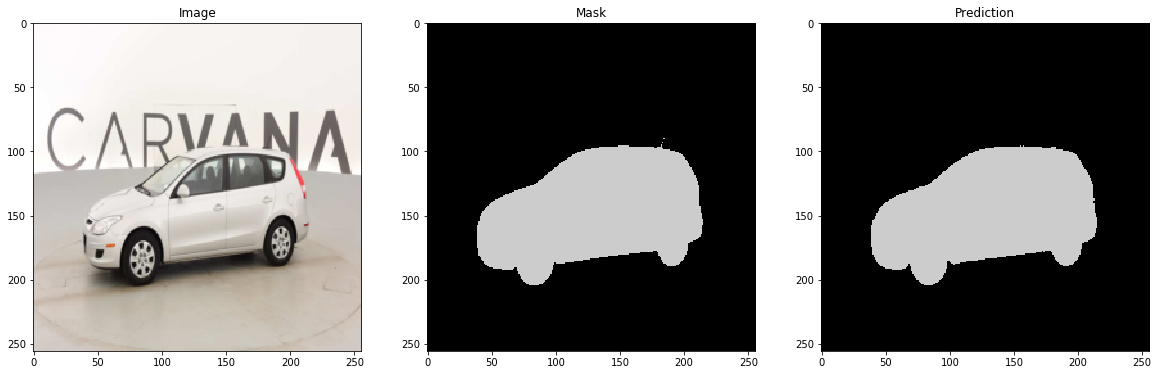

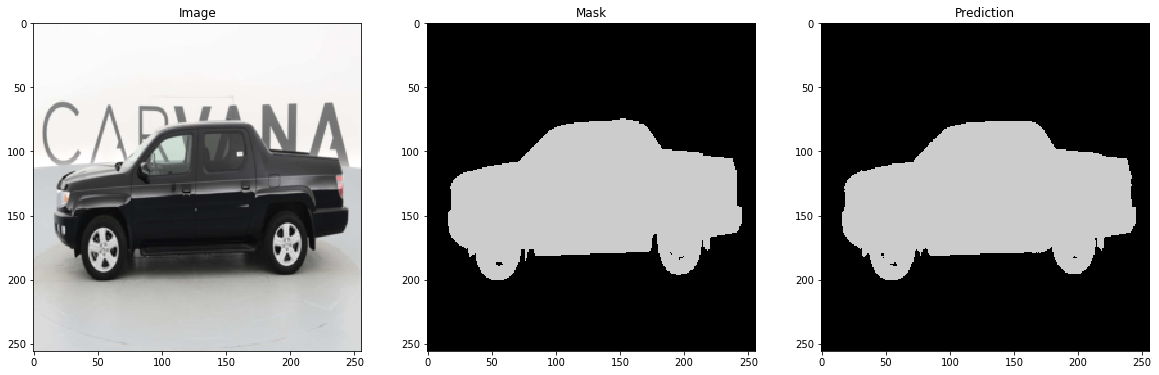

In [26]:
model_preview()

# Testing the Model

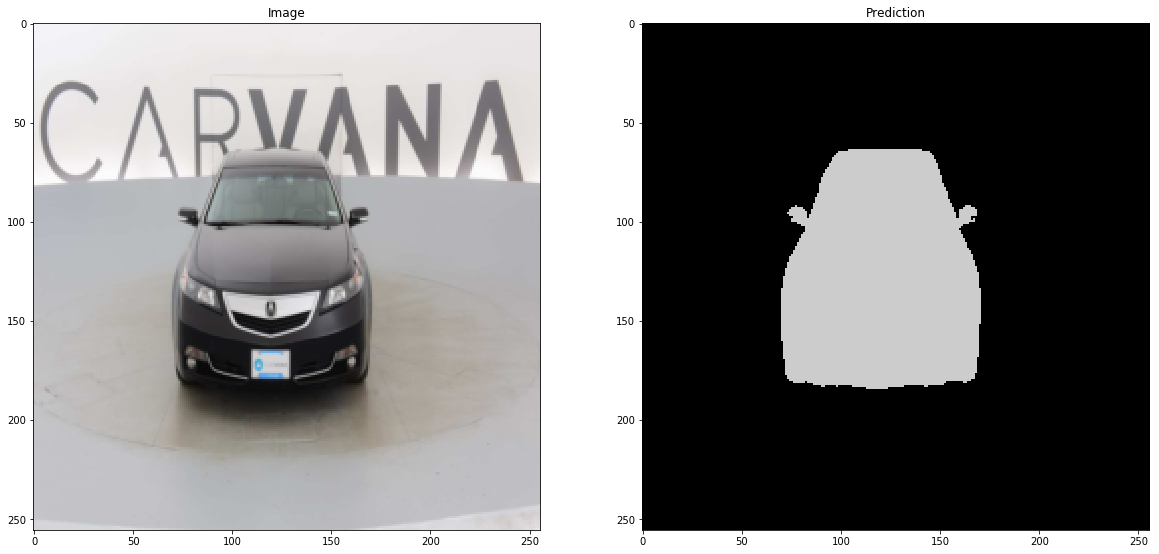

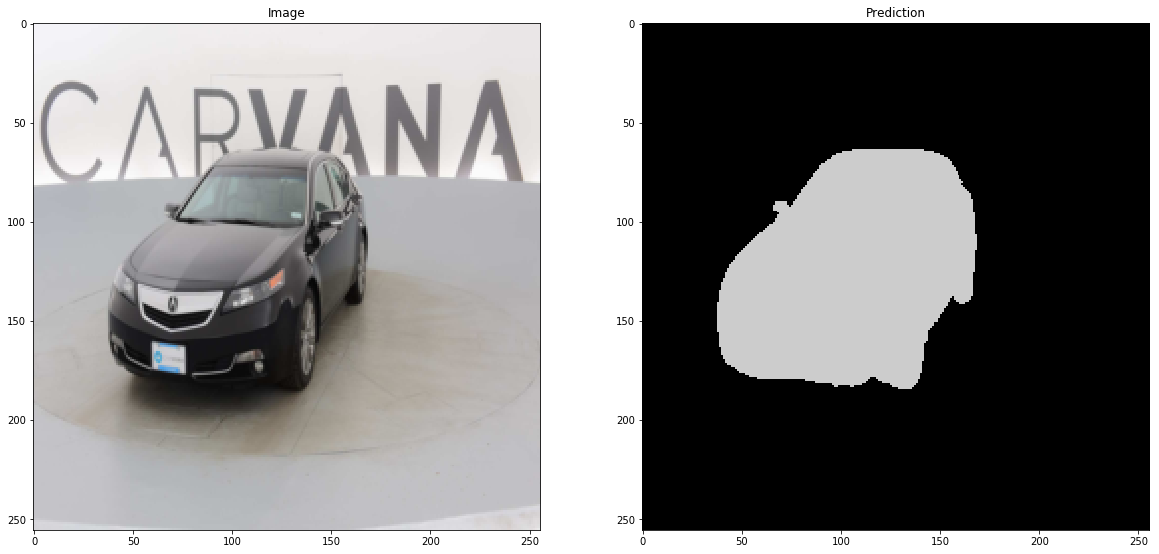

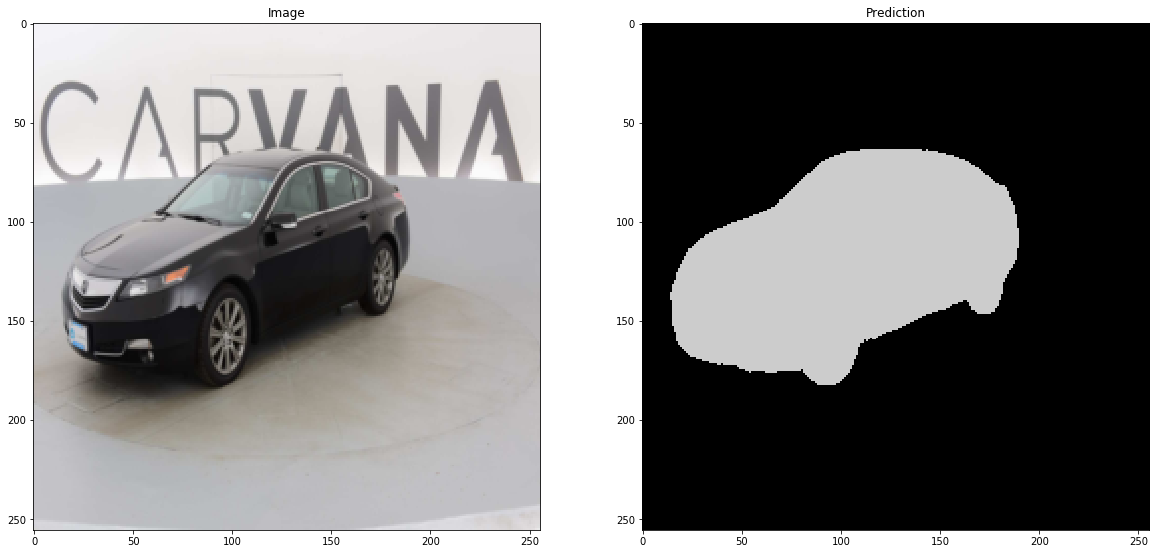

In [18]:
test_data_preview()

# Conclusion

Even after the first epoch both models returned a loss of less than 0.1. This could be a sign of overfitting, but for image masking scores under 90% would likely not be usable. When comparing the models the model that made use of transfer learning performed slightly better in score. However when both models are faced with the test images. It's clear to see that the transfer learning model is creating more confident masks. For the test image, a black car with heavy shadows, it's apparent that the plain U-Net is less confident around the edges. Unfortunately neither model was capable of correctly masking out antennas on a consistent basis. Training with a high resolution may yield better results in this regard.

For further testing I would be interested in trying different resolution to feed into the network. Because I used such a large network I was limited to 256x256 input resolution. A higher resolution may also help the model pick up on antennas. This seemed to be the biggest area of where the model struggled. The second area of weakness makes itself apparent in the test preview. We can see that the dark shadow and black paint proved to be a challenge for the model. Some more image pre-processing might handle this issue.